In [1]:
import h5py
import pandas as pd
import networkx as nx

In [2]:
metadata = pd.read_csv('DataSet3/data_ALL_clusters.csv')
print(metadata.head())

   clusterID  clusterArea  clusterVolume  clusterTime  clusterSpeed
0        0.0       0.0172       0.001712         0.26      0.650433
1        1.0       0.1252       0.026680         0.76      0.725199
2        2.0       0.0068       0.000704         0.16      0.648554
3        3.0       0.0100       0.000880         0.16      0.512835
4        4.0       0.0560       0.002384         0.14      2.548089


In [11]:
with h5py.File('DataSet3/data_clusters_day_180406.h5', 'r') as f:
    print(list(f.keys()))  # Inspect datasets within

    print(dir(f))



['area', 'array_speed', 'file', 'flag', 'shape', 'speed', 'time', 'volume']
['_MutableMapping__marker', '__abstractmethods__', '__bool__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setitem__', '__sizeof__', '__slots__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_d', '_e', '_gcpl_crt_order', '_id', '_in_memory_file_counter', '_ipython_key_completions_', '_lapl', '_lcpl', '_libver', 'attrs', 'build_virtual_dataset', 'clear', 'close', 'copy', 'create_dataset', 'create_dataset_like', 'create_group', 'create_virt

TypeError: 'h5py.h5f.FileID' object is not callable

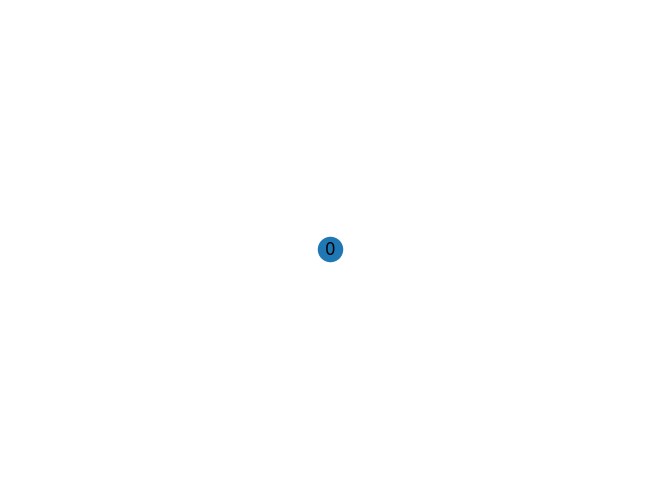

In [13]:

with h5py.File('DataSet3/data_clusters_day_180406.h5', 'r') as f:
    area = f['area'][:]
    speed = f['speed'][:]
    time = f['time'][:]

# Create a graph
G = nx.Graph()

# Add nodes with attributes
for i in range(len(area)):
    G.add_node(i, area=area[i], speed=speed[i], time=time[i])

# Add edges based on proximity (Example: speed similarity)
for i in range(len(area)):
    for j in range(i + 1, len(area)):  # Avoid duplicating edges
        if abs(speed[i] - speed[j]) < 0.5:  # Arbitrary threshold
            G.add_edge(i, j)

# Visualize the graph
nx.draw(G, with_labels=True)